Accuracy of custom random forest classifier on the spam data comes out to be 87.75%

The accuracy of sklearn random forest classifier comes out to be 96%. The accuracy has been claculated for varying max_features technique.

OOB error decreases as we increase the number of estimators to split the data. The plot for various max_features techniques is shown below. 'log2' and 'sqrt' max_features perform better than splitting with all the features, as the no_of_estimators increase.

The code has been written along with brief comments on what the method/statememt does. PFB code.

In [1]:
from __future__ import division
from sklearn import cross_validation
from collections import Counter
import random
import traceback
from scipy.stats import mode
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt
from collections import OrderedDict
import time



/usr/local/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
class CustomRandomForestClassifier(object):
    #A custom made random forest classifier.

    def __init__(self, n_estimators=100, max_features=np.sqrt, max_depth=10,
        mino_of_samples_split=2, bootstrap=1):
        """
        From sklearn website:

            n_estimators: The number of decision trees in the forest.
            max_features: Controls the number of features to randomly consider
                at each split.
            max_depth: The maximum number of levels that the tree can grow
                downwards before forcefully becoming a leaf.
            mino_of_samples_split: The minimum number of samples needed at a node to
                justify a new node split.
            bootstrap: The fraction of randomly choosen data to fit each tree on.
        """
        
        self.n_estimators = n_estimators
        self.max_features = max_features
        self.max_depth = max_depth
        self.mino_of_samples_split = mino_of_samples_split
        self.bootstrap = bootstrap
        self.random_forest = []

    def fit(self, X, y):
        """ Fits the input data to a forest of decision trees using a random subset of data and
            features. """
        self.random_forest = []
        no_of_samples = len(y)
        no_of_sub_samples = round(no_of_samples*self.bootstrap)
        no_of_sub_samples = int(no_of_sub_samples)
        
        for i in xrange(self.n_estimators):
        	shuffle_as_per_data(X, y)
       		X_subset = X[:no_of_sub_samples]
       		y_subset = y[:no_of_sub_samples]
       		tree = DecisionTreeClassifier(self.max_features, self.max_depth,
                                            self.mino_of_samples_split)
        	tree.fit(X_subset, y_subset)
        	self.random_forest.append(tree)
        	

    def predict(self, X):
        """ Predict the class of each sample in X. """
        no_of_samples = X.shape[0]
        no_of_trees = len(self.random_forest)
        predictions = np.empty([no_of_trees, no_of_samples])
        for i in xrange(no_of_trees):
            predictions[i] = self.random_forest[i].predict(X)

        return mode(predictions)[0][0]


    def score(self, X, y):
        """ Return the accuracy of the prediction of X compared to y. """
        y_predict = self.predict(X)
        no_of_samples = len(y)
        correct = 0
        for i in xrange(no_of_samples):
            if y_predict[i] == y[i]:
                correct = correct + 1
        accuracy = correct/no_of_samples
        return accuracy

In [3]:
class DecisionTreeClassifier(object):
    # A decision tree classifier class

    def __init__(self, max_features=lambda x: x, max_depth=10,
                    mino_of_samples_split=2):
        """
        From sklearn website:

            max_features: A function that controls the number of features to
                randomly consider at each split. The argument will be the number
                of features in the data.
            max_depth: The maximum number of levels the tree can grow downwards
                before forcefully becoming a leaf.
            mino_of_samples_split: The minimum number of samples needed at a node to
                justify a new node split.
        """

        self.max_features = max_features
        self.max_depth = max_depth
        self.mino_of_samples_split = mino_of_samples_split


    def fit(self, X, y):
        """ Builds the tree by choosing decision rules for each node based on
        the data """

        no_of_features = X.shape[1]
        no_of_sub_features = int(self.max_features(no_of_features))
        feature_indices = random.sample(xrange(no_of_features), no_of_sub_features)  
        self.trunk = self.build_decision_tree(X, y, feature_indices, 0)


    def predict(self, X):
        """ Predict the class of each sample in X. """

        num_of_samples = X.shape[0]
        y = np.empty(num_of_samples)
        for j in xrange(num_of_samples):
            node = self.trunk

            while isinstance(node, Node):
                if X[j][node.feature_index] <= node.threshold:
                    node = node.positive_branch
                else:
                    node = node.negative_branch
            y[j] = node

        return y


    def build_decision_tree(self, X, y, feature_indices, depth):
        """ Recursivly builds a decision tree. """

        if depth is self.max_depth or len(y) < self.mino_of_samples_split or entropy(y) is 0:
            return mode(y)[0][0]
        
        feature_index, threshold = best_split(X, y, feature_indices)

        X_true, y_true, X_false, y_false = split(X, y, feature_index, threshold)
        if y_true.shape[0] is 0 or y_false.shape[0] is 0:
            return mode(y)[0][0]
        
        positive_branch = self.build_decision_tree(X_true, y_true, feature_indices, depth + 1)
        negative_branch = self.build_decision_tree(X_false, y_false, feature_indices, depth + 1)

        return Node(feature_index, threshold, positive_branch, negative_branch)


In [4]:
def best_split(X, y, feature_indices):
    """ Returns the best split rule for a tree node as per the information gain. """

    num_of_features = X.shape[1]

    best_gain = 0
    best_feature_index = 0
    best_threshold = 0
    for feature_index in feature_indices:
        values = sorted(set(X[:, feature_index])) ### better way

        for j in xrange(len(values) - 1):
            threshold = (values[j] + values[j+1])/2
            X_true, y_true, X_false, y_false = split(X, y, feature_index, threshold)
            gain = information_gain(y, y_true, y_false)

            if gain > best_gain:
                best_gain = gain
                best_feature_index = feature_index
                best_threshold = threshold

    return best_feature_index, best_threshold

In [5]:
class Node(object):
    #A node in a decision tree with the binary condition xi <= t.

    def __init__(self, feature_index, threshold, positive_branch, negative_branch):
        self.feature_index = feature_index
        self.threshold = threshold
        self.positive_branch = positive_branch
        self.negative_branch = negative_branch

In [6]:
def split(X, y, feature_index, threshold):
    """ Splits X and y based on the binary condition xi <= threshold. """

    X_true = []
    y_true = []
    X_false = []
    y_false = []

    for j in xrange(len(y)):
        if X[j][feature_index] <= threshold:
            X_true.append(X[j])
            y_true.append(y[j])
        else:
            X_false.append(X[j])
            y_false.append(y[j])

    X_true = np.array(X_true)
    y_true = np.array(y_true)
    X_false = np.array(X_false)
    y_false = np.array(y_false)

    return X_true, y_true, X_false, y_false

In [7]:
def shuffle_as_per_data(a, b):
    """ Shuffles two lists of equal length and keeps corresponding elements in the same index. """
    rng_state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(rng_state)
    np.random.shuffle(b)

In [8]:
def entropy(Y):
    """ Returns the entropy """
    
    distribution = Counter(Y)
    s = 0.0
    total = len(Y)
    for y, num_y in distribution.items():
        probability_y = (num_y/total)
        s += (probability_y)*np.log(probability_y)
    return -s


def information_gain(y, y_true, y_false):
    """ Returns the reduction in entropy from splitting data into two groups. """
    return entropy(y) - (entropy(y_true)*len(y_true) + entropy(y_false)*len(y_false))/len(y)

In [11]:
dataset=pd.read_csv("/Users/b0203050/Downloads/spam.data.txt",delimiter=" ") # Read data file

X = dataset.iloc[:,0:56].as_matrix() #Independent Variables
y = dataset.iloc[:,57].as_matrix()  #Dependent Variable
min_max_scaler = preprocessing.MinMaxScaler()
X = min_max_scaler.fit_transform(X) #Normalize/scale all data values


X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.30, random_state=10)
#test-train split

forest = CustomRandomForestClassifier()
start_time = time.time()
print "Training a random forest classifier, please wait.."
forest.fit(X_train, y_train)
print("--- Time taken to train a random forest classifier is %s seconds ---" % (time.time() - start_time))

accuracy = forest.score(X_test, y_test)
print 'Accuracy =', 100*accuracy, '% on the test data.'

Training a random forest classifier, please wait..
--- Time taken to train a random forest classifier is 4801.74912095 seconds ---
Accuracy = 87.7536231884 % on the test data.


In [12]:
#Compare time taken and accuracy with different techniques to select max_features

clf = RandomForestClassifier(max_features='sqrt', n_estimators=100, max_depth=10, criterion='entropy', oob_score=True)
start_time = time.time()
clf.fit(X, y)
print clf.score(X_test,y_test)
print("--- Time taken to train a random forest classifier with max features=sqrt is %s seconds ---" % (time.time() - start_time))

start_time = time.time()
clf = RandomForestClassifier(max_features='log2', n_estimators=100, max_depth=10, criterion='entropy', oob_score=True)
clf.fit(X, y)
print clf.score(X_test,y_test)
print("--- Time taken to train a random forest classifier with max features=log2 is %s seconds ---" % (time.time() - start_time))

start_time = time.time()
clf = RandomForestClassifier(max_features=None, n_estimators=100, max_depth=10, criterion='entropy', oob_score=True)
clf.fit(X, y)
print clf.score(X_test,y_test)
print("--- Time taken to train a random forest classifier with max_features=n_features is %s seconds ---" % (time.time() - start_time))


0.964492753623
--- Time taken to train a random forest classifier with max features=sqrt is 0.645182847977 seconds ---
0.958695652174
--- Time taken to train a random forest classifier with max features=log2 is 0.491389989853 seconds ---
0.973188405797
--- Time taken to train a random forest classifier with max_features=n_features is 2.61129188538 seconds ---


/usr/local/lib/python2.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python2.7/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


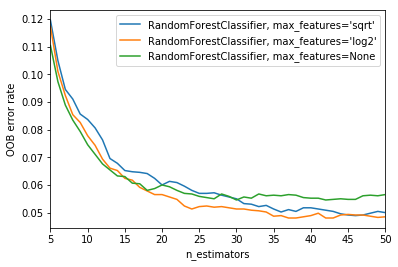

In [13]:
plot_different_clfs = [ ("RandomForestClassifier, max_features='sqrt'", RandomForestClassifier(n_estimators=100, warm_start=True, oob_score=True, max_features="sqrt", random_state=0)), ("RandomForestClassifier, max_features='log2'", RandomForestClassifier(n_estimators=100, warm_start=True, max_features='log2', oob_score=True, random_state=0)), ("RandomForestClassifier, max_features=None", RandomForestClassifier(n_estimators=100, warm_start=True, max_features=None, oob_score=True, random_state=0)) ]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in plot_different_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 5
max_estimators = 50

for label, clf in plot_different_clfs:
    for i in range(min_estimators, max_estimators + 1):
        clf.set_params(n_estimators=i)
        clf.fit(X, y)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()